In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('plot_style_mk.mplstyle')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = ['navy','brown','royalblue'])

# Cleaning the data

In [188]:
file = 'housing_data_hamburg_v2.txt'
df_housing = pd.read_csv(file, sep = '\t', encoding= 'unicode_escape')
df_housing.head()

,Area,Rooms,Rent
0,53 - 115 m²,2 - 4 Zi.,1.645 - 2.942 
1,64.62 m²,3 Zi.,"1.357,02 "
2,90.62 m²,3 Zi.,"1.721,78 "
3,78.24 m²,3 Zi.,"1.760,40 "
4,37.41 - 100.85 m²,1 - 3 Zi.,895 - 1.795 


There are some data points whcih has a range representation rather than just numers and this needs to be removed

In [189]:
outlier_area = []
for area in df_housing['Area']:
    if '-' in str(area):
        print(area)
        outlier_area.append(area)
df_clean = df_housing[df_housing.Area.isin(outlier_area) == False]

53 - 115 m²
37.41 - 100.85 m²
40 - 136 m²
60 - 130 m²
40.4 - 120.4 m²


In [190]:
df_clean = df_clean[df_clean.Rooms.isin(['10 Zi.', '7 Zi.']) == False]

In [191]:
#Checking if there are any rows with missing information
df_clean.isnull().values.any()

True

In [192]:
#removing the rows with null values
df_clean = df_clean.dropna()

In [193]:
#cleaning the area by removing the m^2 end to the string and changing it into a numpy array
#of float data type
area_clean = df_clean['Area'].str.replace(' m²','').astype(float).to_numpy()

In [194]:
#Rent data is quite nasty in this case, thus we need to remove the
#unrecognized unicode symbol, here the euro sign, remove the unnecessary dots used in describing 
#the rent and substitute dot instead of comma and the produce a numpy array of float 
#data types
rent_clean = df_clean['Rent'].str.replace(' ', '')
rent_clean = rent_clean.str.replace('.', '')
rent_clean = rent_clean.str.replace(',', '.').astype(float).to_numpy()

C:\Users\kayanatm\AppData\Local\Temp/ipykernel_34404/2989245527.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  rent_clean = rent_clean.str.replace('.', '')


Text(0, 0.5, 'Rent($in\\;eur$)')

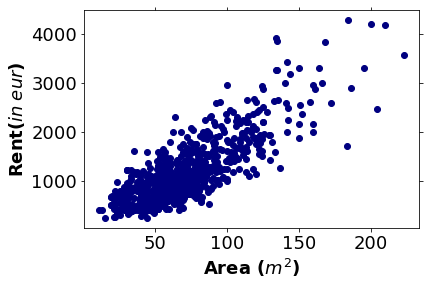

In [195]:
#plotting the area vs rent
fig1, ax1 = plt.subplots()
ax1.scatter(area_clean, rent_clean)
ax1.set_xlabel('Area ($m^2$)')
ax1.set_ylabel('Rent($in\;eur$)')

In [196]:
#Inspecting the number of rooms column
rooms_clean = df_clean['Rooms'].str.replace(' Zi','')
rooms_clean.value_counts()

2.      327
3.      232
1.      143
2.5.     56
4.       56
1.5.     22
5.       12
3.5.     10
4.5.      6
6.        4
5.5.      3
Name: Rooms, dtype: int64

In [197]:
#replacing the unusable notation to usable numbers and creating a numpy array of float type
actual = ['2.5.', '1.5.','3.5.','4.5.', '5.5.']
needed =  ['2.5', '1.5','3.5','4.5','5.5']
for a, n in zip(actual, needed):
    rooms_clean = rooms_clean.str.replace(a,n)
rooms_clean.value_counts()

C:\Users\kayanatm\AppData\Local\Temp/ipykernel_34404/1252654802.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  rooms_clean = rooms_clean.str.replace(a,n)


2.     327
3.     232
1.     143
2.5     56
4.      56
1.5     22
5.      12
3.5     10
4.5      6
6.       4
5.5      3
Name: Rooms, dtype: int64

In [198]:
rooms_clean = rooms_clean.astype(float).to_numpy()

Text(0, 0.5, 'Rent($in\\;eur$)')

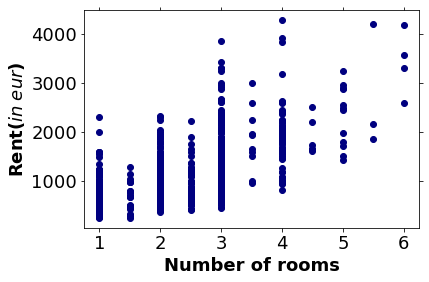

In [199]:
fig2, ax2 = plt.subplots()
ax2.scatter(rooms_clean, rent_clean)
ax2.set_xlabel('Number of rooms')
ax2.set_ylabel('Rent($in\;eur$)')

# Training the model

In [200]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [201]:
x_full = np.stack((area_clean, rooms_clean), axis=1)
x_full.shape

(871, 2)

In [202]:
y_full = rent_clean
y_full.shape

(871,)

In [203]:
x_train = x_full[:650,:]
y_train = y_full[:650]

In [204]:
scalar = StandardScaler()
x_norm = scalar.fit_transform(x_train)

In [205]:
sgdr = SGDRegressor(max_iter=10000)
sgdr.fit(x_norm, y_train)
print(sgdr)
print(f"Number of iterations completed: {sgdr.n_iter_}, Number of weight updates: {sgdr.t_}")
print(sgdr.score(x_norm, y_train))

SGDRegressor(max_iter=10000)
Number of iterations completed: 31, Number of weight updates: 20151.0
0.6620698723695391


In [206]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"Model parameters:                   w: {w_norm}, b:{b_norm}")

Model parameters:                   w: [ 591.34434689 -135.17805773], b:[1107.42485945]


# Predicting the rent

In [207]:
x_test = x_full[650:,:]
y_test = y_full[650:]

x_test_norm = scalar.fit_transform(x_test)

ypred = sgdr.predict(x_test_norm)

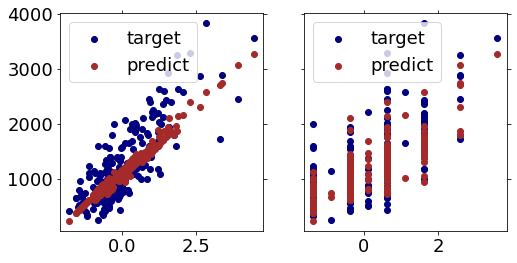

In [208]:
fig3,ax3=plt.subplots(1,2,figsize=(8,4),sharey=True)
for i in range(len(ax3)):
    ax3[i].scatter(x_test_norm[:,i],y_test, label = 'target')
    ax3[i].scatter(x_test_norm[:,i],ypred, label = 'predict')
    ax3[i].legend();

Text(0, 0.5, 'y-predicted')

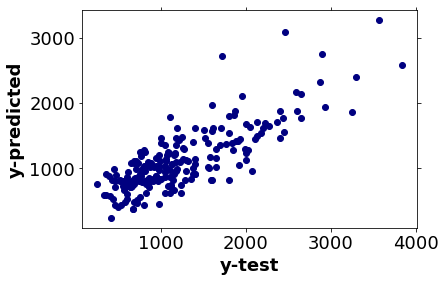

In [209]:
fig4, ax4 = plt.subplots()
ax4.scatter(y_test,ypred)
ax4.set_xlabel('y-test')
ax4.set_ylabel('y-predicted')

# Assessing the perfomance of the model

In [210]:
sgdr.score(x_test_norm, y_test)

0.6312081004537256

In [211]:
def rent_estimator(area, n_rooms):
    x_test_i = np.array([area, n_rooms]).reshape(1,2)
    x_test_norm_i = scalar.fit_transform(x_test_i)
    ypred_i = sgdr.predict(x_test_norm_i)
    
    return ypred_i[0]

rent_estimator(50,1.5)

1107.4248594455555